In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub


path = kagglehub.dataset_download("serenaraju/yawn-eye-dataset-new")

print("Path to dataset files:", path)

100%|██████████| 161M/161M [00:01<00:00, 95.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/serenaraju/yawn-eye-dataset-new/versions/1


In [1]:
from pathlib import Path

folder_path = Path('/content/drive/MyDrive/thesis/yawn-eye-dataset/dataset_new')

subfolders = [f for f in folder_path.iterdir() if f.is_dir()]

print(f"Папки в {folder_path}:")
for subfolder in subfolders:
    print(subfolder)

Папки в /content/drive/MyDrive/thesis/yawn-eye-dataset/dataset_new:
/content/drive/MyDrive/thesis/yawn-eye-dataset/dataset_new/test
/content/drive/MyDrive/thesis/yawn-eye-dataset/dataset_new/train
/content/drive/MyDrive/thesis/yawn-eye-dataset/dataset_new/blind_test
/content/drive/MyDrive/thesis/yawn-eye-dataset/dataset_new/models
/content/drive/MyDrive/thesis/yawn-eye-dataset/dataset_new/my_examples


In [ ]:
import os
blind_test_path = folder_path/'blind_test'
os.makedirs(blind_test_path, exist_ok=True)

In [3]:
from fastai.vision.all import *
import shutil
import os
from sklearn.model_selection import train_test_split

In [ ]:
test_files = get_image_files(folder_path/'test', recurse=True)

test_files, blind_files = train_test_split(test_files, test_size=0.2, random_state=42)

for f in blind_files:
    new_folder = blind_test_path / f.parent.name
    new_folder.mkdir(parents=True, exist_ok=True)
    shutil.move(f, new_folder / f.name)

print(f"Тестових зображень: {len(test_files)}, сліпих зображень: {len(blind_files)}")


Тестових зображень: 346, сліпих зображень: 87


In [ ]:
dls = ImageDataLoaders.from_folder(
    folder_path,
    train='train',
    valid='test',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224),
    bs=32
)

In [ ]:
learn = vision_learner(dls, models.efficientnet_b0, metrics=[error_rate, accuracy]).to_fp16()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 157MB/s]


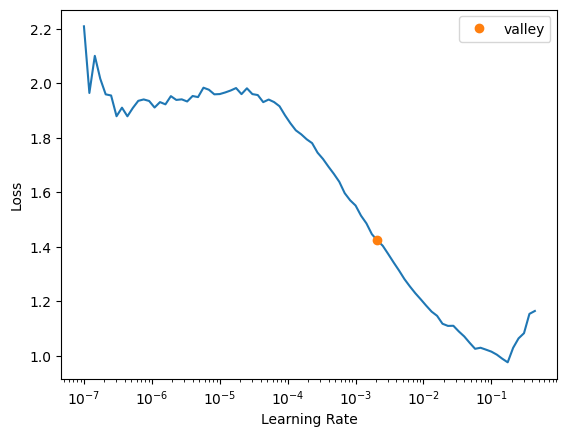

In [ ]:
lr_find_result = learn.lr_find()
if isinstance(lr_find_result, tuple) and len(lr_find_result) == 2:
    lr_min, lr_steep = lr_find_result
else:
    lr_min = lr_find_result
    lr_steep = None

In [ ]:
print(f"Мінімальний learning rate: {lr_min}")
if lr_steep is not None:
    print(f"Крута точка learning rate: {lr_steep}")
else:
    print("Крута точка не була знайдена.")

Мінімальний learning rate: SuggestedLRs(valley=0.0020892962347716093)
Крута точка не була знайдена.


In [ ]:
learn.fine_tune(20, base_lr=0.00208)

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.509870,0.232370,0.069364,0.930636,03:32


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.286940,0.124286,0.043353,0.956647,00:28
1,0.264641,0.088050,0.037572,0.962428,00:28
2,0.206794,0.057533,0.014451,0.985549,00:30
3,0.176880,0.028496,0.014451,0.985549,00:29
4,0.151775,0.050842,0.017341,0.982659,00:29
5,0.147918,0.041137,0.023121,0.976879,00:27
6,0.117496,0.033324,0.017341,0.982659,00:30
7,0.108738,0.033548,0.023121,0.976879,00:30
8,0.088792,0.035524,0.011561,0.988439,00:29
9,0.091843,0.017727,0.008671,0.991329,00:30


KeyboardInterrupt: 

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

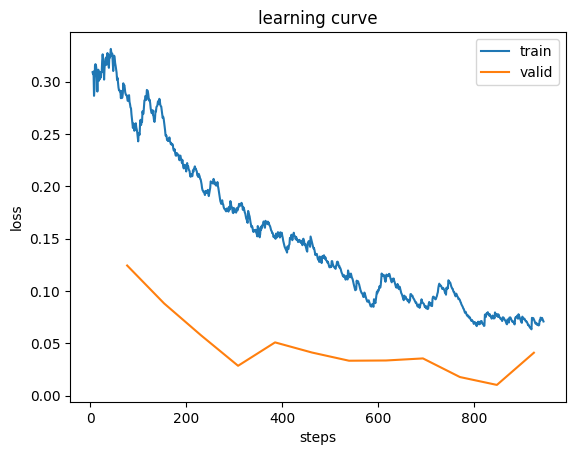

In [ ]:
learn.recorder.plot_loss()

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.286940,0.124286,0.043353,0.956647,00:28
1,0.264641,0.088050,0.037572,0.962428,00:28
2,0.206794,0.057533,0.014451,0.985549,00:30
3,0.176880,0.028496,0.014451,0.985549,00:29
4,0.151775,0.050842,0.017341,0.982659,00:29
5,0.147918,0.041137,0.023121,0.976879,00:27
6,0.117496,0.033324,0.017341,0.982659,00:30
7,0.108738,0.033548,0.023121,0.976879,00:30
8,0.088792,0.035524,0.011561,0.988439,00:29
9,0.091843,0.017727,0.008671,0.991329,00:30


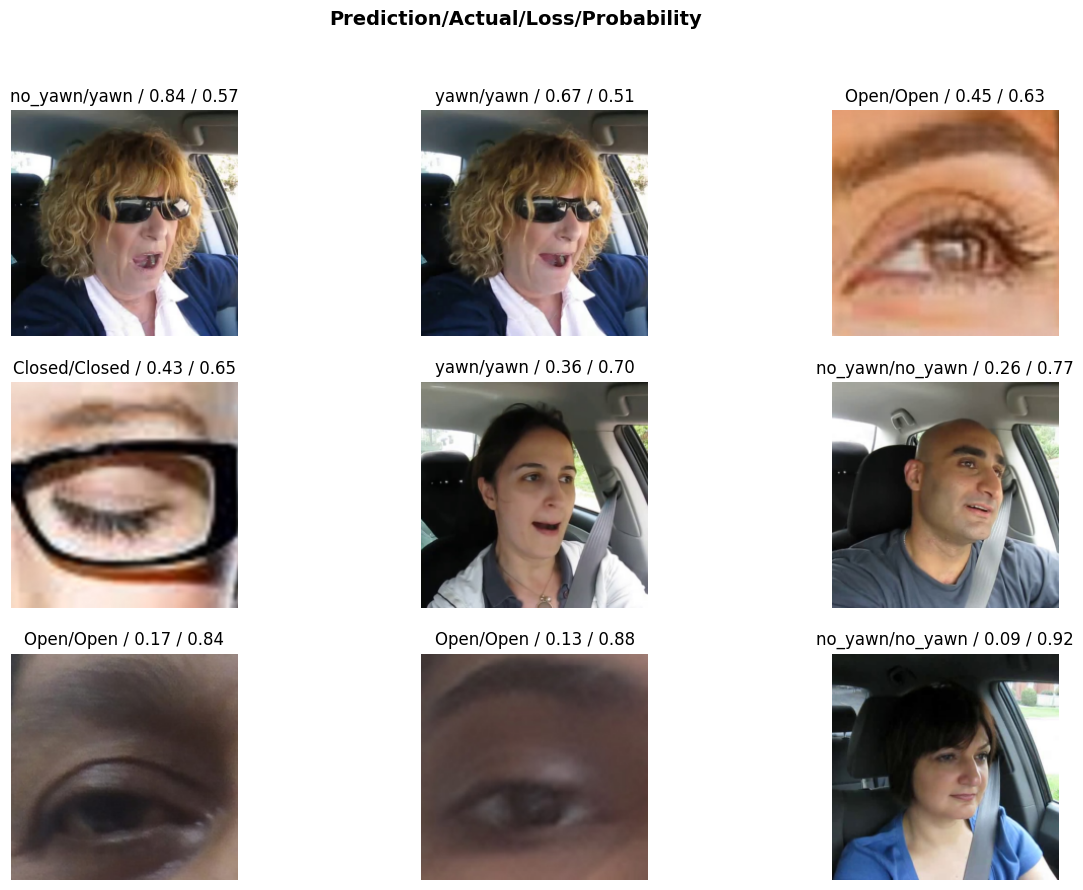

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
learn.export(folder_path/'yawn_eye_model.pkl')

In [ ]:
blind_dls = ImageDataLoaders.from_folder(
    folder_path,
    valid='blind_test',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224),
    bs=32
)

In [ ]:
learn = load_learner(folder_path/'yawn_eye_model.pkl')

In [ ]:
preds, _, decoded_preds = learn.get_preds(dl=blind_dls.valid, with_decoded=True)

for i in range(10):
    print(f"Файл: {blind_dls.valid.items[i].name} → Передбачення: {learn.dls.vocab[decoded_preds[i]]}")

Файл: _719.jpg → Передбачення: Closed
Файл: _586.jpg → Передбачення: Closed
Файл: _559.jpg → Передбачення: Closed
Файл: _7.jpg → Передбачення: Closed
Файл: _107.jpg → Передбачення: Closed
Файл: _542.jpg → Передбачення: Closed
Файл: _529.jpg → Передбачення: Closed
Файл: _605.jpg → Передбачення: Closed
Файл: _609.jpg → Передбачення: Closed
Файл: _515.jpg → Передбачення: Closed


In [4]:
learn.export(folder_path/'yawn_eye_model.pkl')

NameError: name 'learn' is not defined

In [5]:
blind_dls = ImageDataLoaders.from_folder(
    folder_path,
    valid='my_examples',
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224),
    bs=32
)

In [6]:
learn = load_learner(folder_path/'yawn_eye_model.pkl')

In [7]:
preds, _, decoded_preds = learn.get_preds(dl=blind_dls.valid, with_decoded=True)

for i in range(31):
    print(f"Файл: {blind_dls.valid.items[i].name} → Передбачення: {learn.dls.vocab[decoded_preds[i]]}")

Файл: s2.jpg → Передбачення: Open
Файл: s4.jpeg → Передбачення: Open
Файл: s3.jpeg → Передбачення: Open
Файл: a1.jpg → Передбачення: Open
Файл: se2.jpg → Передбачення: no_yawn
Файл: se3.jpg → Передбачення: Open
Файл: o1.jpg → Передбачення: Open
Файл: o2.jpg → Передбачення: Open
Файл: s1.jpeg → Передбачення: Closed
Файл: a2.jpg → Передбачення: Closed
Файл: se1.jpg → Передбачення: Closed
Файл: o3.jpg → Передбачення: Closed
Файл: s6.jpeg → Передбачення: yawn
Файл: s5.jpeg → Передбачення: yawn
Файл: a4.jpg → Передбачення: yawn
Файл: se7.jpg → Передбачення: yawn
Файл: o8.jpg → Передбачення: yawn
Файл: o9.jpg → Передбачення: yawn
Файл: o10.jpg → Передбачення: yawn
Файл: s7.jpeg → Передбачення: no_yawn
Файл: a3.jpg → Передбачення: no_yawn
Файл: a5.jpg → Передбачення: no_yawn
Файл: se4.jpg → Передбачення: no_yawn
Файл: se5.jpg → Передбачення: no_yawn
Файл: se6.jpg → Передбачення: no_yawn
Файл: se8.jpg → Передбачення: no_yawn
Файл: se9.jpg → Передбачення: no_yawn
Файл: o4.jpg → Передбачення: no